<a href="https://colab.research.google.com/github/danidedavid/Time-Series-Forecasting---ML-Regression-Project/blob/main/01_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 — Análise Exploratória de Dados (EDA) — Vendas
Objetivos:
- Carregar e padronizar o dataset mensal (itens × lojas × período).
- Entender estrutura, valores faltantes, zeros e outliers.
- Visão de sazonalidade e tendências por período/loja/item.
- Salvar uma base **limpa** para os próximos notebooks.


In [2]:

# ============================
# 0) IMPORTS & CONFIG
# ============================
import os, sys, gc, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

# Carregar dataset
CANDIDATE_PATHS = ["/content/base_mensal.csv"]
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Nome dos campos esperados (serão inferidos automaticamente)
COLUMN_ALIASES = {
    "date": ["year_month","data","periodo","period","mes_ano","dt","date","ym","month_year"],
    "item": ["item","sku","produto","product_id","id_item"],
    "store": ["store","loja","id_loja","shop","filial"],
    "sales": ["sales","vendas","qtd_vendas","valor_vendas","demand","y"],
    "price": ["mean_price","price","preco","preço","avg_price","unit_price"],
    "promo": ["promo","promocao","promotion","is_promo","flag_promo"],
    "category": ["category","categoria","cat"],
    "department": ["department","departamento","dept"],
    "region": ["region","regiao","região","area"]
}

def _infer_col(cols, aliases):
    cols_lower = {c.lower(): c for c in cols}
    for a in aliases:
        if a.lower() in cols_lower:
            return cols_lower[a.lower()]
    return None

def infer_columns(df):
    mapping = {}
    for logical, aliases in COLUMN_ALIASES.items():
        col = _infer_col(df.columns, aliases)
        mapping[logical] = col
    # Campos obrigatórios mínimos
    required = ["date","item","store","sales"]
    missing = [k for k in required if mapping.get(k) is None]
    if missing:
        raise ValueError(f"Não encontrei colunas mínimas {missing}. Colunas disponíveis: {list(df.columns)}")
    return mapping

def try_read_csv(paths):
    last_err = None
    for p in paths:
        if os.path.exists(p):
            try:
                df = pd.read_csv(p)
                print(f"[OK] Lido: {p} -> shape {df.shape}")
                return df, p
            except Exception as e:
                last_err = e
    raise FileNotFoundError(f"Não consegui ler o CSV nas opções {paths}. Último erro: {last_err}")

df_raw, used_path = try_read_csv(CANDIDATE_PATHS)
mapping = infer_columns(df_raw)

DATE_COL  = mapping["date"]
ITEM_COL  = mapping["item"]
STORE_COL = mapping["store"]
SALES_COL = mapping["sales"]
PRICE_COL = mapping["price"]        # pode ser None
PROMO_COL = mapping["promo"]        # pode ser None
CAT_COL   = mapping["category"]     # pode ser None
DEPT_COL  = mapping["department"]   # pode ser None
REG_COL   = mapping["region"]       # pode ser None

print("[MAPPING]")
print(json.dumps(mapping, indent=2, ensure_ascii=False))

# Parse datas (mensal por padrão). Tenta múltiplos formatos.
df = df_raw.copy()
def _to_period_month(x):
    x = str(x)
    for fmt in ("%Y-%m","%Y/%m","%Y%m","%d/%m/%Y","%Y-%m-%d"):
        try:
            return pd.to_datetime(x, format=fmt).to_period("M").to_timestamp()
        except Exception:
            pass
    # tentativa mais flexível
    try:
        return pd.to_datetime(x).to_period("M").to_timestamp()
    except Exception:
        return pd.NaT

df[DATE_COL] = df[DATE_COL].apply(_to_period_month)
if df[DATE_COL].isna().any():
    n_bad = df[DATE_COL].isna().sum()
    print(f"[WARN] {n_bad} datas não puderam ser parseadas e serão removidas.")
    df = df.dropna(subset=[DATE_COL])

# Tipos
df[ITEM_COL]  = df[ITEM_COL].astype("string")
df[STORE_COL] = df[STORE_COL].astype("string")
if CAT_COL:  df[CAT_COL]  = df[CAT_COL].astype("string")
if DEPT_COL: df[DEPT_COL] = df[DEPT_COL].astype("string")
if REG_COL:  df[REG_COL]  = df[REG_COL].astype("string")

# Ordena
df = df.sort_values([DATE_COL, STORE_COL, ITEM_COL]).reset_index(drop=True)

print(df.head(3))
print(df.dtypes)
print(df.describe(include="all").transpose().head(20))


[OK] Lido: /content/base_mensal.csv -> shape (1951360, 10)
[MAPPING]
{
  "date": "year_month",
  "item": "item",
  "store": "store",
  "sales": "sales",
  "price": "mean_price",
  "promo": null,
  "category": "category",
  "department": "department",
  "region": "region"
}
  year_month                      id              item    category  \
0 2011-01-01  ACCESORIES_1_001_BOS_3  ACCESORIES_1_001  ACCESORIES   
1 2011-01-01  ACCESORIES_1_002_BOS_3  ACCESORIES_1_002  ACCESORIES   
2 2011-01-01  ACCESORIES_1_003_BOS_3  ACCESORIES_1_003  ACCESORIES   

     department     store store_code  region  sales  mean_price  
0  ACCESORIES_1  Back_Bay      BOS_3  Boston      0         NaN  
1  ACCESORIES_1  Back_Bay      BOS_3  Boston      0         NaN  
2  ACCESORIES_1  Back_Bay      BOS_3  Boston      0         NaN  
year_month    datetime64[ns]
id                    object
item          string[python]
category      string[python]
department    string[python]
store         string[python]
store_c

## 1) Checagens básicas

In [3]:

# Duplicados e linhas com NA em chaves
dups = df.duplicated(subset=[DATE_COL, STORE_COL, ITEM_COL]).sum()
print(f"[CHECK] Duplicados (date, store, item): {dups}")
na_keys = df[[DATE_COL, STORE_COL, ITEM_COL]].isna().any(axis=1).sum()
print(f"[CHECK] NA em chaves: {na_keys}")

# Vendas zero e faltantes
zero_sales = (df[SALES_COL] == 0).sum()
na_sales   = df[SALES_COL].isna().sum()
print(f"[CHECK] Vendas==0: {zero_sales} | Vendas NA: {na_sales}")

# Resumo de NA por coluna
na_sum = df.isna().sum().sort_values(ascending=False)
display(na_sum.head(20))


[CHECK] Duplicados (date, store, item): 0
[CHECK] NA em chaves: 0
[CHECK] Vendas==0: 589041 | Vendas NA: 0


,0
mean_price,414540
year_month,0
id,0
item,0
department,0
category,0
store,0
store_code,0
region,0
sales,0


## 2) Visão geral de séries

[INFO] Lojas: 10 | Itens: 3049 | Meses: 64 | Registros: 1951360


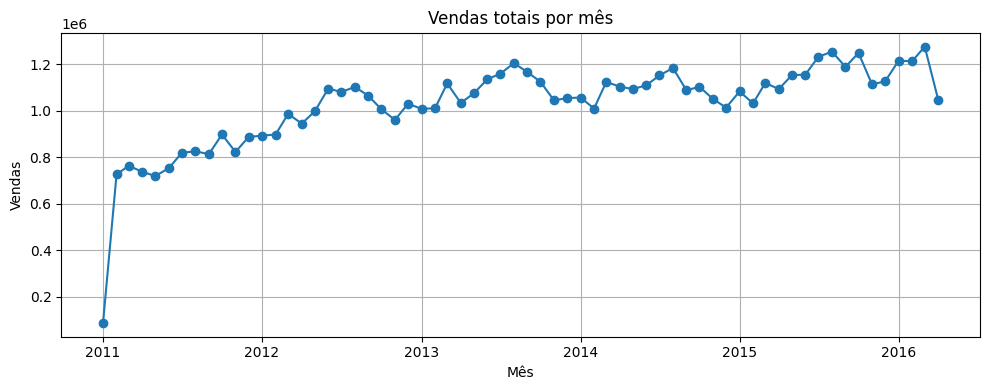

,total_vendas
store,
Tribeca,11188180
Greenwich_Village,7698216
Roxbury,7214384
Yorktown,6544012
Queen_Village,6427782
Back_Bay,6089330
Harlem,5685475
South_End,5595292
Midtown_Village,5149062


,total_vendas
item,
SUPERMARKET_3_090,1002529
SUPERMARKET_3_586,920242
SUPERMARKET_3_252,565299
SUPERMARKET_3_555,491287
SUPERMARKET_3_714,396172
SUPERMARKET_3_587,396119
SUPERMARKET_3_694,390001
SUPERMARKET_3_226,363082
SUPERMARKET_3_202,295689


In [4]:

# Séries por loja e item
n_stores = df[STORE_COL].nunique()
n_items  = df[ITEM_COL].nunique()
n_dates  = df[DATE_COL].nunique()
print(f"[INFO] Lojas: {n_stores} | Itens: {n_items} | Meses: {n_dates} | Registros: {len(df)}")

# Totais mensais (toda a rede)
totals = df.groupby(DATE_COL, as_index=False)[SALES_COL].sum()
fig = plt.figure(figsize=(10,4))
plt.plot(totals[DATE_COL], totals[SALES_COL], marker="o")
plt.title("Vendas totais por mês")
plt.xlabel("Mês"); plt.ylabel("Vendas")
plt.grid(True); plt.tight_layout(); plt.show()

# Top lojas / itens por volume total
top_stores = df.groupby(STORE_COL)[SALES_COL].sum().sort_values(ascending=False).head(10)
top_items  = df.groupby(ITEM_COL)[SALES_COL].sum().sort_values(ascending=False).head(10)
display(top_stores.to_frame("total_vendas"))
display(top_items.to_frame("total_vendas"))


## 3) Sazonalidade (séries agregadas)

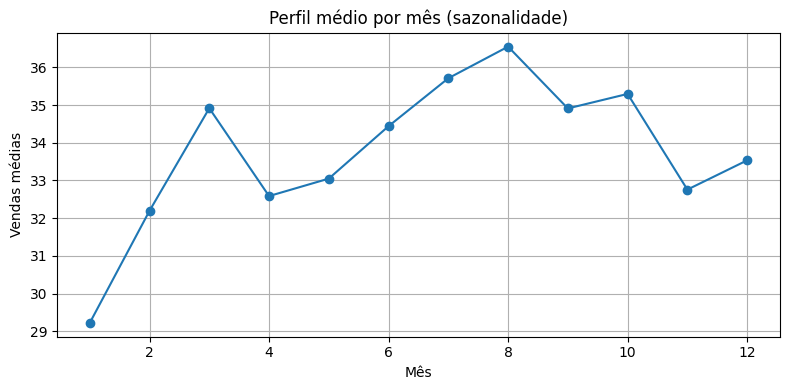

In [5]:

# Sazonalidade média por mês do ano
df["_month"] = df[DATE_COL].dt.month
month_profile = df.groupby("_month")[SALES_COL].mean()
fig = plt.figure(figsize=(8,4))
plt.plot(month_profile.index, month_profile.values, marker="o")
plt.title("Perfil médio por mês (sazonalidade)")
plt.xlabel("Mês"); plt.ylabel("Vendas médias")
plt.grid(True); plt.tight_layout(); plt.show()


## 4) Correlações rápidas (numéricas)

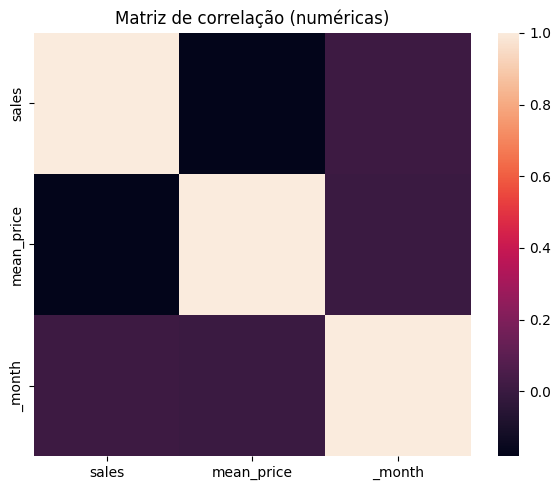

In [6]:

import numpy as np
num_df = df.select_dtypes(include=[np.number]).copy()
if num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=False)
    plt.title("Matriz de correlação (numéricas)")
    plt.tight_layout(); plt.show()
else:
    print("[INFO] Poucas variáveis numéricas para correlação.")


## 5) Salvar base limpa para os próximos notebooks

In [7]:

clean_path_parquet = os.path.join(OUTPUT_DIR, "base_mensal_clean.parquet")
df.to_parquet(clean_path_parquet, index=False)
print(f"[OK] Salvo: {clean_path_parquet}")


[OK] Salvo: ./outputs/base_mensal_clean.parquet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')